In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# A neural network with u_n， θ_c
# u_d = K(θ_c) u_n
# u_d(x) = \int K(x, y, θ_c) u_n(y) dy
class DirectKernelNet(nn.Module):

    def __init__(self, N_θ):
        super(DirectKernelNet, self).__init__()
        self.N_θ = N_θ
        # an affine operation: y = Wx + b
        
        self.fc1 = nn.Linear(N_θ + 2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x



In [2]:
L = 1.0

# load data 
θ = np.load("uniform_direct_theta.npy")
κ = np.load("uniform_direct_K.npy")

N_data, N_θ =  θ.shape
N_x, N_y, N_data = κ.shape

# todo debug
N_data = 1


assert(N_x == N_y)
Δx = L/(N_x - 1)

input_train  = np.zeros((N_data * N_x * N_y, (N_θ + 2)), dtype=np.float32) # θ, x, y
output_train = np.zeros((N_data * N_x * N_y), dtype=np.float32)

xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

# test
i = 20
j = 40
assert(X[i, j] == i*Δx and Y[i, j] == j*Δx)



for i in range(N_data):
    d_range = range(i*N_x*N_y, (i + 1)*N_x*N_y)
    input_train[d_range , 0:N_θ] = θ[i]
    input_train[d_range , N_θ] = X.reshape(-1)
    input_train[d_range , N_θ + 1] = Y.reshape(-1)
    
    output_train[d_range] = κ[:, :, i].reshape(-1)
    



x_train = torch.from_numpy(input_train) 
y_train = torch.from_numpy(output_train).unsqueeze(-1)



In [3]:
# preprocess the training data 

class DirectData(Dataset):

    def __init__(self, X, y):
        
        self.X = X if torch.is_tensor(X) else torch.from_numpy(X)
        self.y = y if torch.is_tensor(y) else torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = DirectData(X=x_train, y=y_train)
ds = DataLoader(ds, batch_size=512, shuffle=True)



# training with adam
model = DirectKernelNet(N_θ)
loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

n_epochs = 5000
for epoch in range(n_epochs):
    
    for ix, (_x, _y) in enumerate(ds):
    
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(_x)

        # Compute and print loss.
        loss = loss_fn(y_pred, _y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
    if epoch % 100 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        

[0/5000], loss: 16544.383
[100/5000], loss: 14990.496
[200/5000], loss: 4585.764
[300/5000], loss: 4436.217
[400/5000], loss: 4154.348
[500/5000], loss: 4205.465
[600/5000], loss: 3147.906
[700/5000], loss: 3429.953
[800/5000], loss: 3267.588
[900/5000], loss: 3018.768
[1000/5000], loss: 2506.771
[1100/5000], loss: 2581.554
[1200/5000], loss: 2223.385
[1300/5000], loss: 1679.538
[1400/5000], loss: 1321.748
[1500/5000], loss: 1235.406
[1600/5000], loss: 1118.649
[1700/5000], loss: 1114.685
[1800/5000], loss: 871.428
[1900/5000], loss: 859.316
[2000/5000], loss: 934.412
[2100/5000], loss: 870.01
[2200/5000], loss: 868.006
[2300/5000], loss: 699.207
[2400/5000], loss: 778.881
[2500/5000], loss: 839.895
[2600/5000], loss: 690.446
[2700/5000], loss: 612.119
[2800/5000], loss: 624.25
[2900/5000], loss: 753.388
[3000/5000], loss: 706.425
[3100/5000], loss: 597.536
[3200/5000], loss: 486.178
[3300/5000], loss: 436.236
[3400/5000], loss: 425.556
[3500/5000], loss: 352.826
[3600/5000], loss: 357

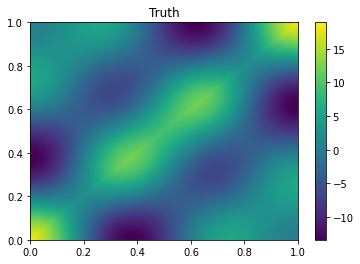

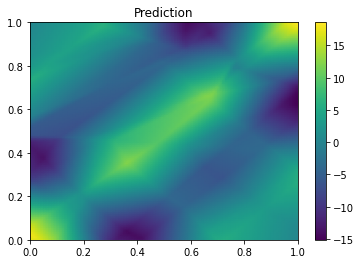

In [13]:
# test on training data

test_id = 0

input_test = np.zeros((N_x * N_y, (N_θ + 2)), dtype=np.float32) # θ, x, y
output_test = np.zeros((N_x * N_y), dtype=np.float32)

input_test[: , 0:N_θ] = θ[test_id]
input_test[: , N_θ] = X.reshape(-1)
input_test[: , N_θ+1] = Y.reshape(-1)
output_test = model(torch.from_numpy(input_test))
κ_pred = output_test.detach().numpy().reshape((N_x, N_y))

vmin, vmax = np.min(κ[:, :, test_id]), np.max(κ[:, :, test_id])
fig = plt.figure()
plt.pcolormesh(X, Y, κ[:, :, test_id], shading="gouraud")
plt.colorbar()
plt.title("Truth")
fig.savefig("Truth%i.png" % test_id)

fig = plt.figure()
plt.pcolormesh(X, Y, κ_pred, shading="gouraud")
plt.colorbar()
plt.title("Prediction")
fig.savefig("Prediction%i.png" % test_id)


In [10]:
i

0

In [67]:
# training with BFGS

model = DirectKernelNet(N_θ)
loss_fn = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8, max_iter=1000, line_search_fn='strong_wolfe')

for t in range(20):    
    def closure():
        optimizer.zero_grad()

        y_pred = model(x_train)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_train)
        
        print(t, loss.item())
        
        loss.backward()
        return loss

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step(closure)
    

0 360947.125
0 361147.75
0 360830.9375
0 360830.6875
0 360832.21875
0 360830.375
0 360830.8125
0 360830.28125
0 360830.1875
0 360829.875
0 360829.875
1 360829.875
1 360829.90625
1 360829.875
1 360829.875
1 360829.875
1 360829.875
1 360829.875
2 360829.875
2 360829.90625
2 360829.875
2 360829.875
2 360829.875
2 360829.875
2 360829.875
3 360829.875
3 360829.90625
3 360829.875
3 360829.875
3 360829.875
3 360829.875
3 360829.875
4 360829.875
4 360829.90625
4 360829.875
4 360829.875
4 360829.875
4 360829.875
4 360829.875
5 360829.875
5 360829.90625
5 360829.875
5 360829.875
5 360829.875
5 360829.875
5 360829.875
6 360829.875
6 360829.90625
6 360829.875
6 360829.875
6 360829.875
6 360829.875
6 360829.875
7 360829.875
7 360829.90625
7 360829.875
7 360829.875
7 360829.875
7 360829.875
7 360829.875
8 360829.875
8 360829.90625
8 360829.875
8 360829.875
8 360829.875
8 360829.875
8 360829.875
9 360829.875
9 360829.90625
9 360829.875
9 360829.875
9 360829.875
9 360829.875
9 360829.875
10 360829.875

In [70]:

    
a = x_train.detach().numpy()
a   

array([[3.8422382e+01, 0.0000000e+00, 0.0000000e+00],
       [3.8422382e+01, 0.0000000e+00, 9.9999998e-03],
       [3.8422382e+01, 0.0000000e+00, 2.0000000e-02],
       ...,
       [3.8422382e+01, 1.0000000e+00, 9.8000002e-01],
       [3.8422382e+01, 1.0000000e+00, 9.9000001e-01],
       [3.8422382e+01, 1.0000000e+00, 1.0000000e+00]], dtype=float32)

In [64]:
θ.shape

(100, 1)